In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import StackingRegressor, StackingClassifier, RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasRegressor, KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# Data Prepararion 

In [85]:
cols = ['word_freq_make','word_freq_address','word_freq_all','word_freq_3d','word_freq_our',
'word_freq_over','word_freq_remove','word_freq_internet','word_freq_order',
'word_freq_mail','word_freq_receive','word_freq_will','word_freq_people','word_freq_report',
'word_freq_addresses','word_freq_free','word_freq_business','word_freq_email','word_freq_you',
'word_freq_credit','word_freq_your','word_freq_font','word_freq_000','word_freq_money','word_freq_hp',
'word_freq_hpl','word_freq_george','word_freq_650','word_freq_lab','word_freq_labs',
'word_freq_telnet''word_freq_857','word_freq_data','word_freq_415','word_freq_85','word_freq_technology',
'word_freq_1999','word_freq_parts','word_freq_pm','word_freq_direct','word_freq_cs','word_freq_meeting',
'word_freq_original','word_freq_project','word_freq_re','word_freq_edu','word_freq_table',
'word_freq_conference','char_freq_1','char_freq_2','char_freq_3','char_freq_4',
'char_freq_5','char_freq_6','wf','capital_run_length_average','capital_run_length_longest',
'capital_run_length_total','prediction']
data = pd.read_csv('spambase.data', names=cols, index_col=False)
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_2,char_freq_3,char_freq_4,char_freq_5,char_freq_6,wf,capital_run_length_average,capital_run_length_longest,capital_run_length_total,prediction
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [86]:
X = data.drop(['prediction'], axis=1)
y = data[['prediction']]

In [87]:
X_xgb = data.drop(['prediction'], axis=1)
y_xgb = data[['prediction']]

In [88]:
# Split training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [89]:
# Split training and testing set
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.3, random_state=42)

In [90]:
# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Modeling(i) : best accuracy

In [91]:
# Nasted cross-validation
inner_cv = KFold(n_splits=4, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

## Tuning Hyperparameter

In [92]:
#RandomForest
rf = RandomForestClassifier()
criterion = ['gini', 'entropy']
max_depth =  list(range(1,10)) 
min_samples_split = list(range(2,10)) 
rf_grid = {'criterion' : criterion, 'max_depth' : max_depth, 'min_samples_split': min_samples_split}

# KNN
knn = KNeighborsClassifier()
weights = ['uniform', 'distance']
k_values = list(range(1,30))
knn_grid = {'weights' : weights,'n_neighbors': k_values}

# SVM
svm = SVC(probability = True)
kernel = ['rbf']
g = [0.001, 0.01, 0.1, 1, 10, 100] 
c = [0.1, 1, 10, 100]
s_grid = {'kernel':kernel, 'C':c, 'gamma':g }

# GradientBoosting
gb = GradientBoostingClassifier()
n_estimators = np.array([50, 100, 200, 300, 400, 500])
max_depth = list(range(1,10))
learning_rate = np.array([0.01, 0.1, 0.2, 0.3])
gb_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate}

# XGBoost
xg = XGBClassifier()
max_depth = list(range(1,10)) 
learning_rate = np.array([0.01, 0.1, 0.2, 0.3])
n_estimators = np.array([50, 100, 200, 300, 400, 500])
objective =['binary:logistic']
xg_grid = {'max_depth': max_depth, 'learning_rate': learning_rate, 'n_estimators':n_estimators, 'objective':objective}

## Non-nested parameter search and scoring

In [93]:
rf_clf = RandomizedSearchCV(rf, rf_grid, n_iter=20, cv=inner_cv, scoring='accuracy')
knn_clf = GridSearchCV(knn, knn_grid, cv=inner_cv, scoring='accuracy')
svm_clf = GridSearchCV(svm, s_grid, cv=inner_cv, scoring='accuracy')
gb_clf = RandomizedSearchCV(gb, gb_grid, n_iter=20, cv=inner_cv, scoring='accuracy')
xg_clf = RandomizedSearchCV(xg, xg_grid, n_iter=20, cv=inner_cv, scoring='accuracy')

## Nested CV with parameter optimization

In [94]:
rf_score = cross_val_score(rf_clf,X=X_train, y=y_train, cv=outer_cv)
knn_score = cross_val_score(knn_clf,X=X_train, y=y_train, cv=outer_cv)
svm_score = cross_val_score(svm_clf,X=X_train,y=y_train, cv=outer_cv)
gb_score = cross_val_score(gb_clf, X=X_train, y=y_train, cv=outer_cv) 
xg_score = cross_val_score(xg_clf, X=X_train_xgb, y=y_train_xgb, cv=outer_cv) 

## Model Selection

In [95]:
score = {}
score['Random Forest'] = rf_score.mean()
score['KNN'] = knn_score.mean()
score['SVM'] = svm_score.mean()
score['GradientBoosting'] = gb_score.mean()
score['XGBoost'] = xg_score.mean()
score

{'Random Forest': 0.9372670807453416,
 'KNN': 0.9130434782608697,
 'SVM': 0.9298136645962733,
 'GradientBoosting': 0.9493788819875778,
 'XGBoost': 0.9503105590062113}

# (i) Best model: XGBoost

In [130]:
# Tuning Hyperparameter
max_depth = list(range(1,10)) 
learning_rate = np.array([0.01, 0.1, 0.2, 0.3])
n_estimators = np.array([50, 100, 200, 300, 400, 500])
objective =['binary:logistic']
xg_grid = {'max_depth': max_depth, 'learning_rate': learning_rate, 'n_estimators':n_estimators, 'objective':objective}

# build the model
xg = XGBClassifier()

# Non-nested parameter search and scoring
xg_clf = RandomizedSearchCV(xg, xg_grid, n_iter=20, cv=inner_cv, scoring='accuracy')

In [131]:
# fit the model
xg_clf.fit(X_train_xgb, y_train_xgb)
y_train_xg = xg_clf.predict(X_train_xgb)
y_pred_xg = xg_clf.predict(X_test_xgb)

## Evaluate

The best parameters: {'objective': 'binary:logistic', 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.3}

The XGBoost model performs exceptionally well on the training set, achieving an accuracy of approximately 99.9% and with an accuracy of approximately 96% on testing data.

In [132]:
print('best params: ', xg_clf.best_params_)
print('best score: ', xg_clf.best_score_)
print('Training set score:', accuracy_score(y_train_xgb, y_train_xg))
print('Testing set score:', accuracy_score(y_test_xgb, y_pred_xg))
print(confusion_matrix(y_test_xgb, y_pred_xg))
print(classification_report(y_test_xgb, y_pred_xg))

best params:  {'objective': 'binary:logistic', 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.3}
best score:  0.9475155279503106
Training set score: 0.9990683229813665
Testing set score: 0.9601737871107893
[[779  25]
 [ 30 547]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       804
           1       0.96      0.95      0.95       577

    accuracy                           0.96      1381
   macro avg       0.96      0.96      0.96      1381
weighted avg       0.96      0.96      0.96      1381



<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

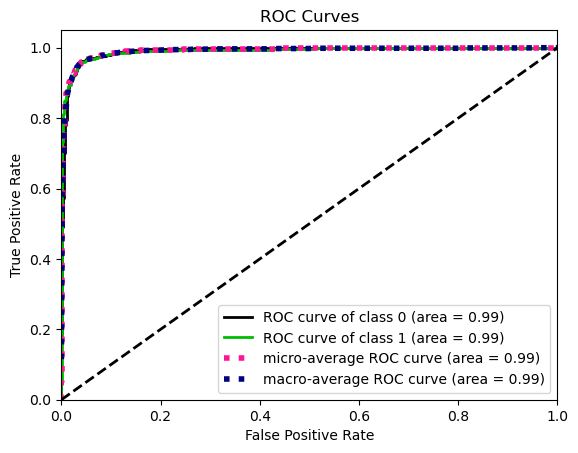

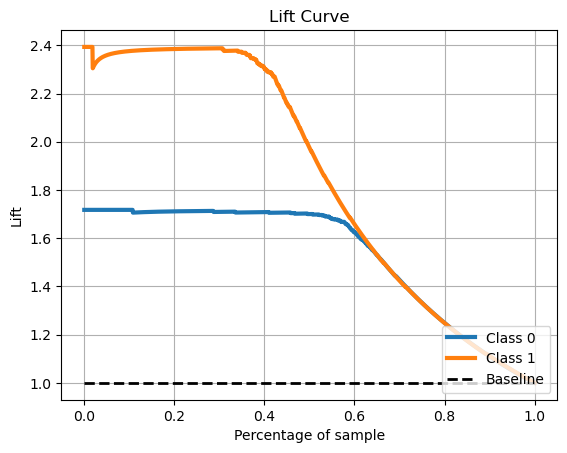

In [133]:
prob = xg_clf.predict_proba(X_test_xgb)
skplt.metrics.plot_roc(y_test_xgb, prob)
skplt.metrics.plot_lift_curve(y_test_xgb, prob)

# Modeling(ii) : best cost-sensitive
### I use 10 for false positive and 1 for false negative

In [100]:
def cost(true, pred):
    cm = confusion_matrix(true, pred)
    cost = cm[0][1] * 10 + cm[1][0] * 1
    return cost

mis_cost = make_scorer(cost, greater_is_better= False)

## Tuning Hyperparameter

In [101]:
# RandomForest
rf = RandomForestClassifier()
criterion = ['gini', 'entropy']
max_depth =  list(range(1,10)) 
min_samples_split = list(range(2,10)) 
rf_grid = {'criterion' : criterion, 'max_depth' : max_depth, 'min_samples_split': min_samples_split}

# KNN
knn = KNeighborsClassifier()
weights = ['uniform', 'distance']
k_values = list(range(1,30))
knn_grid = {'weights' : weights,'n_neighbors': k_values}

# SVM
svm = SVC(probability = True)
kernel = ['rbf']
g = [0.001, 0.01, 0.1, 1, 10, 100] 
c = [0.1, 1, 10, 100]
s_grid = {'kernel':kernel, 'C':c, 'gamma':g }

# GradientBoosting
gb = GradientBoostingClassifier()
n_estimators = np.array([50, 100, 200, 300, 400, 500])
max_depth = list(range(1,10))
learning_rate = np.array([0.01, 0.1, 0.2, 0.3])
gb_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate}

# XGBoost
xg = XGBClassifier()
max_depth = list(range(1,10)) 
learning_rate = np.array([0.01, 0.1, 0.2, 0.3])
n_estimators = np.array([50, 100, 200, 300, 400, 500])
objective =['binary:logistic']
xg_grid = {'max_depth': max_depth, 'learning_rate': learning_rate, 'n_estimators':n_estimators, 'objective':objective}

## Non-nested parameter search and scoring

In [102]:
rf_clf = RandomizedSearchCV(rf, rf_grid, n_iter=20, cv=inner_cv, scoring=mis_cost)
knn_clf = GridSearchCV(knn, knn_grid, cv=inner_cv, scoring=mis_cost)
svm_clf = GridSearchCV(svm, s_grid, cv=inner_cv, scoring=mis_cost)
gb_clf = RandomizedSearchCV(gb, gb_grid, n_iter=20, cv=inner_cv, scoring=mis_cost)
xg_clf = RandomizedSearchCV(xg, xg_grid, n_iter=20, cv=inner_cv, scoring=mis_cost)

## Nested CV with parameter optimization

In [103]:
rf_cost = cross_val_score(rf_clf,X=X_train, y=y_train, cv=outer_cv)
knn_cost = cross_val_score(knn_clf,X=X_train, y=y_train, cv=outer_cv)
svm_cost = cross_val_score(svm_clf,X=X_train,y=y_train, cv=outer_cv)
gb_cost = cross_val_score(gb_clf, X=X_train, y=y_train, cv=outer_cv) 
xg_cost = cross_val_score(xg_clf, X=X_train_xgb, y=y_train_xgb, cv=outer_cv) 

## Model Selection

In [104]:
cost = {}
cost['Random Forest'] = -rf_cost.mean()
cost['KNN'] = -knn_cost.mean()
cost['SVM'] = -svm_cost.mean()
cost['GradientBoosting'] = -gb_cost.mean()
cost['XGBoosting'] = -xg_cost.mean()
cost

{'Random Forest': 149.6,
 'KNN': 221.4,
 'SVM': 152.4,
 'GradientBoosting': 154.4,
 'XGBoosting': 165.8}

# (ii) Best cost sensitive model: Random Forest

In [119]:
# Tuning Hyperparameter
criterion = ['gini', 'entropy']
max_depth =  list(range(1,10)) 
min_samples_split = list(range(2,10)) 
rf_grid = {'criterion' : criterion, 'max_depth' : max_depth, 'min_samples_split': min_samples_split}

# build the model
rf = RandomForestClassifier()

# Non-nested parameter search and scoring
# rf_clf = RandomizedSearchCV(rf, rf_grid, n_iter=20, cv=inner_cv, scoring=mis_cost)
rf_clf = GridSearchCV(rf, rf_grid, cv=inner_cv, scoring=mis_cost)

In [120]:
# fit the model
rf_clf.fit(X_train, y_train)
y_train_rf = rf_clf.predict(X_train)
y_pred_rf = rf_clf.predict(X_test)

## Evaluation

In [121]:
print('best params: ', rf_clf.best_params_)
print('best score: ', -rf_clf.best_score_)
print('Training set score:', accuracy_score(y_train, y_train_rf))
print('Testing set score:', accuracy_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

best params:  {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 2}
best score:  167.0
Training set score: 0.9602484472049689
Testing set score: 0.940622737146995
[[784  20]
 [ 62 515]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       804
           1       0.96      0.89      0.93       577

    accuracy                           0.94      1381
   macro avg       0.94      0.93      0.94      1381
weighted avg       0.94      0.94      0.94      1381



<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

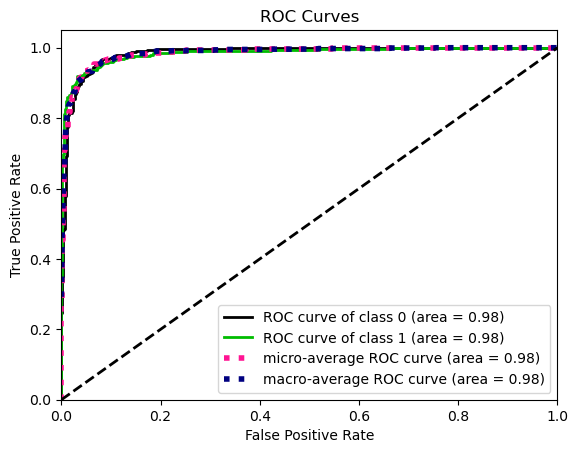

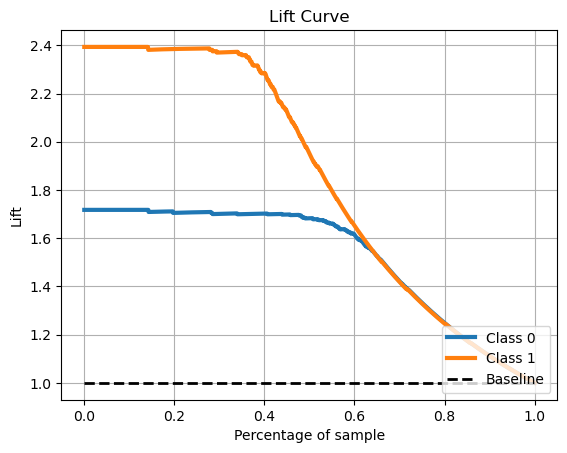

In [122]:
prob = rf_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, prob)
skplt.metrics.plot_lift_curve(y_test, prob)

In [123]:
cm = confusion_matrix(y_test, y_pred_rf)
cost = cm[0][1]*10 + cm[1][0]*1
avg_cost = cost/(cm.sum())
print('The cost is', cost)
print('The average misclassification cost is', avg_cost)

The cost is 262
The average misclassification cost is 0.18971759594496743


# Conclusion

- Modeling (i): This model is optimized for accuracy, achieving a high testing set accuracy of 96.02%. It uses a 'binary:logistic' objective and is ideal for tasks where maximizing accuracy is the primary goal.

- Modeling (ii): Designed for cost-sensitive performance, this model focuses on minimizing misclassification costs. While it has a slightly lower testing set accuracy of 94.06%, it excels at cost reduction, achieving a misclassification cost of 262 and an average cost of 0.18. It's a strong choice when minimizing the financial impact of misclassifications is crucial.